In [69]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Generic imports
import os
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

# ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf
from keras.models import load_model

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [71]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [72]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

plot_style_3 = {'histtype': 'step', 'linewidth': 2, 'alpha':0.5, 'density': True}

# OmniFold with Gaussians

We first unfold data in the case that there are no MC generation weights from simulated events.

In [73]:
### Generating the data

N = 10**6 # Sample size

# Generate truth (particle-level)
sim_params = (10, 1) # parameters for simulation truth
data_params = (1, 1.5) # parameters for data truth

# Truth distributions are Normal(μ, σ²)
sim_truth = np.random.normal(sim_params[0], sim_params[1], N)
data_truth = np.random.normal(data_params[0], data_params[1], N)


# Generate reco (detector-level)
eps = 1 # smearing width

# Reconstruction distributions are Normal(μ, σ² + ε²)
sim_reco = sim_truth + np.random.normal(0, eps, N)
data_reco = data_truth + np.random.normal(0, eps, N)

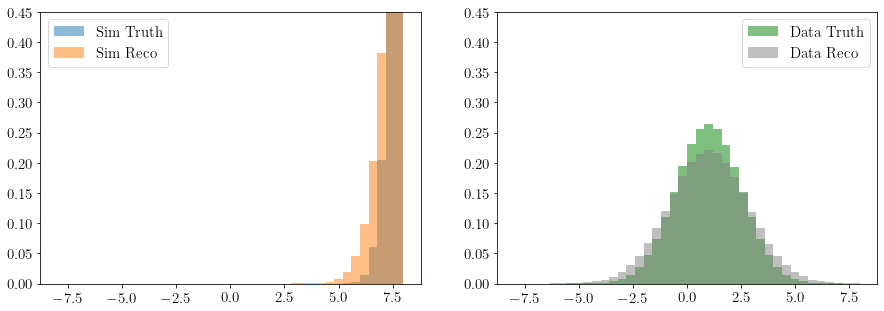

In [74]:
### Plotting the data

bins = np.linspace(-8, 8, 41)

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].hist(sim_truth, alpha = 0.5, bins = bins, density = True, label = 'Sim Truth')
axs[0].hist(sim_reco, alpha = 0.5, bins = bins, density = True, label = 'Sim Reco')
axs[0].set_ylim(0, 0.45)
axs[0].legend();

axs[1].hist(data_truth, alpha = 0.5, bins = bins, density = True, label = 'Data Truth', color = 'g')
axs[1].hist(data_reco, alpha = 0.5, bins = bins, density = True, label = 'Data Reco', color = 'gray')
axs[1].set_ylim(0, 0.45)
axs[1].legend();

## Classifier Training

In [75]:
# We first train the classifier to distinguish between
# simulation and data.

# Inputs are the observed values.
# Outputs are labels: 0 = Sim, 1 = Data.
xs_1 = np.concatenate((sim_reco, data_reco))
ys_1 = np.concatenate((np.zeros(N), np.ones(N)))

w_pull = np.ones(N)
v_push = np.ones(N)

In [76]:
# Create our neural network. It has 3 layers, with 50
# nodes each. The network takes as input one observed
# value. The output is the predicted label, as a 
# value in [0, 1].
inputs = Input(shape = (1, ))
layer_1 = Dense(50, activation = 'relu')(inputs)
layer_2 = Dense(50, activation = 'relu')(layer_1)
layer_3 = Dense(50, activation = 'relu')(layer_2)
outputs = Dense(1, activation = 'sigmoid')(layer_3)

classifier = Model(inputs = inputs, outputs = outputs)

earlystopping = EarlyStopping(patience = 10, verbose = 1,
                              restore_best_weights = True)

In [77]:
# Now we train our classifier on the data.
def bce(y_true, y_pred):
    eps = K.epsilon()
    y_pred = K.clip(y_pred, eps, 1. - eps)
    
    return K.mean( (y_true) * K.log(y_pred) + 
                   (1 - y_true) * K.log(1 - y_pred)
                 )

X_train, X_test, y_train, y_test = train_test_split(xs_1, ys_1)

In [53]:
classifier.compile(loss = bce,
              optimizer = 'Adam',
              metrics = ['accuracy'])

classifier.fit(X_train, 
          y_train,
          epochs = 200, 
          batch_size = 10000, 
          validation_data = (X_test, y_test), 
          callbacks = [earlystopping], 
          verbose = 1)

Epoch 1/200
150/150 [==============================] - ETA: 0s - loss: -1.0232 - accuracy: 0.509 - ETA: 1s - loss: -1.4414 - accuracy: 0.413 - ETA: 1s - loss: -1.9922 - accuracy: 0.387 - ETA: 0s - loss: -2.6318 - accuracy: 0.380 - ETA: 0s - loss: -3.5582 - accuracy: 0.375 - ETA: 0s - loss: -4.4923 - accuracy: 0.372 - ETA: 0s - loss: -5.1474 - accuracy: 0.370 - ETA: 0s - loss: -5.6243 - accuracy: 0.367 - ETA: 0s - loss: -5.9889 - accuracy: 0.365 - ETA: 0s - loss: -6.2608 - accuracy: 0.362 - ETA: 0s - loss: -6.5324 - accuracy: 0.358 - ETA: 0s - loss: -6.7914 - accuracy: 0.354 - ETA: 0s - loss: -7.0104 - accuracy: 0.348 - ETA: 0s - loss: -7.2544 - accuracy: 0.340 - ETA: 0s - loss: -7.4632 - accuracy: 0.331 - ETA: 0s - loss: -7.6682 - accuracy: 0.320 - ETA: 0s - loss: -7.8793 - accuracy: 0.306 - ETA: 0s - loss: -8.1379 - accuracy: 0.290 - ETA: 0s - loss: -8.3832 - accuracy: 0.276 - ETA: 0s - loss: -8.6955 - accuracy: 0.262 - ETA: 0s - loss: -8.9900 - accuracy: 0.250 - 1s 9ms/step - loss: -

150/150 [==============================] - ETA: 0s - loss: -15.9569 - accuracy: 0.00 - ETA: 0s - loss: -15.9640 - accuracy: 0.00 - ETA: 0s - loss: -15.9620 - accuracy: 0.00 - ETA: 0s - loss: -15.9598 - accuracy: 0.00 - ETA: 0s - loss: -15.9594 - accuracy: 0.00 - ETA: 0s - loss: -15.9578 - accuracy: 0.00 - ETA: 0s - loss: -15.9576 - accuracy: 0.00 - ETA: 0s - loss: -15.9576 - accuracy: 0.00 - ETA: 0s - loss: -15.9581 - accuracy: 0.00 - ETA: 0s - loss: -15.9584 - accuracy: 0.00 - ETA: 0s - loss: -15.9586 - accuracy: 0.00 - ETA: 0s - loss: -15.9591 - accuracy: 0.00 - ETA: 0s - loss: -15.9593 - accuracy: 0.00 - ETA: 0s - loss: -15.9593 - accuracy: 0.00 - ETA: 0s - loss: -15.9594 - accuracy: 0.00 - ETA: 0s - loss: -15.9595 - accuracy: 0.00 - ETA: 0s - loss: -15.9599 - accuracy: 0.00 - ETA: 0s - loss: -15.9602 - accuracy: 0.00 - ETA: 0s - loss: -15.9599 - accuracy: 0.00 - ETA: 0s - loss: -15.9600 - accuracy: 0.00 - ETA: 0s - loss: -15.9605 - accuracy: 0.00 - ETA: 0s - loss: -15.9608 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9634 - accuracy: 0.00 - ETA: 0s - loss: -15.9734 - accuracy: 0.00 - ETA: 0s - loss: -15.9734 - accuracy: 0.00 - ETA: 0s - loss: -15.9742 - accuracy: 0.00 - ETA: 1s - loss: -15.9749 - accuracy: 0.00 - ETA: 0s - loss: -15.9757 - accuracy: 0.00 - ETA: 0s - loss: -15.9761 - accuracy: 0.00 - ETA: 0s - loss: -15.9757 - accuracy: 0.00 - ETA: 0s - loss: -15.9750 - accuracy: 0.00 - ETA: 0s - loss: -15.9752 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accuracy: 0.00 - ETA: 0s - loss: -15.9745 - accuracy: 0.00 - ETA: 0s - loss: -15.9745 - accuracy: 0.00 - ETA: 0s - loss: -15.9747 - accuracy: 0.00 - ETA: 0s - loss: -15.9747 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accuracy: 0.00 - ETA: 0s - loss: -15.9747 - accuracy: 0.00 - ETA: 0s - loss: -15.9745 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accuracy: 0.00 - ETA: 0s - loss: -15.9747 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9691 - accuracy: 0.00 - ETA: 0s - loss: -15.9740 - accuracy: 0.00 - ETA: 1s - loss: -15.9741 - accuracy: 0.00 - ETA: 0s - loss: -15.9748 - accuracy: 0.00 - ETA: 1s - loss: -15.9763 - accuracy: 0.00 - ETA: 1s - loss: -15.9772 - accuracy: 0.00 - ETA: 0s - loss: -15.9778 - accuracy: 0.00 - ETA: 0s - loss: -15.9784 - accuracy: 0.00 - ETA: 0s - loss: -15.9786 - accuracy: 0.00 - ETA: 0s - loss: -15.9777 - accuracy: 0.00 - ETA: 0s - loss: -15.9780 - accuracy: 0.00 - ETA: 0s - loss: -15.9784 - accuracy: 0.00 - ETA: 0s - loss: -15.9784 - accuracy: 0.00 - ETA: 0s - loss: -15.9783 - accuracy: 0.00 - ETA: 0s - loss: -15.9782 - accuracy: 0.00 - ETA: 0s - loss: -15.9782 - accuracy: 0.00 - ETA: 0s - loss: -15.9782 - accuracy: 0.00 - ETA: 0s - loss: -15.9784 - accuracy: 0.00 - ETA: 0s - loss: -15.9788 - accuracy: 0.00 - ETA: 0s - loss: -15.9786 - accuracy: 0.00 - ETA: 0s - loss: -15.9790 - accuracy: 0.00 - ETA: 0s - loss: -15.9791 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9811 - accuracy: 0.00 - ETA: 1s - loss: -15.9845 - accuracy: 0.00 - ETA: 1s - loss: -15.9833 - accuracy: 0.00 - ETA: 1s - loss: -15.9829 - accuracy: 0.00 - ETA: 1s - loss: -15.9832 - accuracy: 0.00 - ETA: 1s - loss: -15.9839 - accuracy: 0.00 - ETA: 1s - loss: -15.9840 - accuracy: 0.00 - ETA: 1s - loss: -15.9826 - accuracy: 0.00 - ETA: 1s - loss: -15.9827 - accuracy: 0.00 - ETA: 1s - loss: -15.9820 - accuracy: 0.00 - ETA: 1s - loss: -15.9824 - accuracy: 0.00 - ETA: 0s - loss: -15.9818 - accuracy: 0.00 - ETA: 0s - loss: -15.9822 - accuracy: 0.00 - ETA: 0s - loss: -15.9820 - accuracy: 0.00 - ETA: 0s - loss: -15.9814 - accuracy: 0.00 - ETA: 0s - loss: -15.9816 - accuracy: 0.00 - ETA: 0s - loss: -15.9816 - accuracy: 0.00 - ETA: 0s - loss: -15.9817 - accuracy: 0.00 - ETA: 0s - loss: -15.9817 - accuracy: 0.00 - ETA: 0s - loss: -15.9818 - accuracy: 0.00 - ETA: 0s - loss: -15.9819 - accuracy: 0.00 - ETA: 0s - loss: -15.9820 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9775 - accuracy: 0.00 - ETA: 0s - loss: -15.9842 - accuracy: 0.00 - ETA: 0s - loss: -15.9842 - accuracy: 0.00 - ETA: 0s - loss: -15.9828 - accuracy: 0.00 - ETA: 0s - loss: -15.9828 - accuracy: 0.00 - ETA: 0s - loss: -15.9819 - accuracy: 0.00 - ETA: 0s - loss: -15.9818 - accuracy: 0.00 - ETA: 0s - loss: -15.9830 - accuracy: 0.00 - ETA: 0s - loss: -15.9829 - accuracy: 0.00 - ETA: 0s - loss: -15.9832 - accuracy: 0.00 - ETA: 0s - loss: -15.9839 - accuracy: 0.00 - ETA: 0s - loss: -15.9838 - accuracy: 0.00 - ETA: 0s - loss: -15.9840 - accuracy: 0.00 - ETA: 0s - loss: -15.9838 - accuracy: 0.00 - ETA: 0s - loss: -15.9836 - accuracy: 0.00 - ETA: 0s - loss: -15.9836 - accuracy: 0.00 - ETA: 0s - loss: -15.9836 - accuracy: 0.00 - ETA: 0s - loss: -15.9838 - accuracy: 0.00 - ETA: 0s - loss: -15.9839 - accuracy: 0.00 - ETA: 0s - loss: -15.9840 - accuracy: 0.00 - 1s 8ms/step - loss: -15.9840 - accuracy: 0.0026 - val_loss: -15.9855 - val_ac

150/150 [==============================] - ETA: 0s - loss: -15.9849 - accuracy: 0.00 - ETA: 0s - loss: -15.9892 - accuracy: 0.00 - ETA: 0s - loss: -15.9862 - accuracy: 0.00 - ETA: 0s - loss: -15.9844 - accuracy: 0.00 - ETA: 0s - loss: -15.9846 - accuracy: 0.00 - ETA: 0s - loss: -15.9851 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9863 - accuracy: 0.00 - ETA: 0s - loss: -15.9862 - accuracy: 0.00 - ETA: 0s - loss: -15.9862 - accuracy: 0.00 - ETA: 0s - loss: -15.9860 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9862 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9856 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9848 - accuracy: 0.00 - ETA: 0s - loss: -15.9847 - accuracy: 0.00 - 1s 9ms/step - loss: -15.9847 - ac

150/150 [==============================] - ETA: 0s - loss: -15.9929 - accuracy: 0.00 - ETA: 0s - loss: -15.9854 - accuracy: 0.00 - ETA: 0s - loss: -15.9833 - accuracy: 0.00 - ETA: 0s - loss: -15.9829 - accuracy: 0.00 - ETA: 0s - loss: -15.9836 - accuracy: 0.00 - ETA: 0s - loss: -15.9823 - accuracy: 0.00 - ETA: 0s - loss: -15.9825 - accuracy: 0.00 - ETA: 0s - loss: -15.9823 - accuracy: 0.00 - ETA: 0s - loss: -15.9839 - accuracy: 0.00 - ETA: 0s - loss: -15.9839 - accuracy: 0.00 - ETA: 0s - loss: -15.9845 - accuracy: 0.00 - ETA: 0s - loss: -15.9847 - accuracy: 0.00 - ETA: 0s - loss: -15.9850 - accuracy: 0.00 - ETA: 0s - loss: -15.9850 - accuracy: 0.00 - ETA: 0s - loss: -15.9854 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9860 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9862 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9958 - accuracy: 0.00 - ETA: 0s - loss: -15.9820 - accuracy: 0.00 - ETA: 0s - loss: -15.9832 - accuracy: 0.00 - ETA: 0s - loss: -15.9846 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9851 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9858 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9860 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9861 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - 1s 8ms/step - loss: -15.9859 - ac

150/150 [==============================] - ETA: 0s - loss: -15.9696 - accuracy: 0.00 - ETA: 0s - loss: -15.9851 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9886 - accuracy: 0.00 - ETA: 0s - loss: -15.9892 - accuracy: 0.00 - ETA: 0s - loss: -15.9888 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9871 - accuracy: 0.00 - ETA: 0s - loss: -15.9875 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9875 - accuracy: 0.00 - ETA: 0s - loss: -15.9875 - accuracy: 0.00 - ETA: 0s - loss: -15.9873 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9873 - accuracy: 0.00 - ETA: 0s - loss: -15.9875 - accuracy: 0.00 - 1s 9ms/step - loss: -15.9876 - ac

150/150 [==============================] - ETA: 0s - loss: -15.9815 - accuracy: 0.00 - ETA: 0s - loss: -15.9912 - accuracy: 0.00 - ETA: 0s - loss: -15.9895 - accuracy: 0.00 - ETA: 0s - loss: -15.9886 - accuracy: 0.00 - ETA: 0s - loss: -15.9888 - accuracy: 0.00 - ETA: 0s - loss: -15.9881 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9889 - accuracy: 0.00 - ETA: 0s - loss: -15.9889 - accuracy: 0.00 - ETA: 0s - loss: -15.9883 - accuracy: 0.00 - ETA: 0s - loss: -15.9880 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9880 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9872 - accuracy: 0.00 - ETA: 0s - loss: -15.9872 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9869 - accuracy: 0.00 - 1s 9ms/step - loss: -15.9870 - ac

150/150 [==============================] - ETA: 0s - loss: -15.9751 - accuracy: 0.00 - ETA: 0s - loss: -15.9891 - accuracy: 0.00 - ETA: 0s - loss: -15.9867 - accuracy: 0.00 - ETA: 1s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9860 - accuracy: 0.00 - ETA: 0s - loss: -15.9855 - accuracy: 0.00 - ETA: 0s - loss: -15.9861 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9863 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accuracy: 0.00 - ETA: 0s - loss: -15.9858 - accuracy: 0.00 - ETA: 0s - loss: -15.9863 - accuracy: 0.00 - ETA: 0s - loss: -15.9860 - accuracy: 0.00 - ETA: 0s - loss: -15.9864 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9867 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9866 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9869 - accuracy: 0.00 - ETA: 0s - loss: -15.9869 - accuracy: 0.00 - ETA: 0s - loss: -15.9870 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9897 - accuracy: 0.00 - ETA: 1s - loss: -15.9894 - accuracy: 0.00 - ETA: 1s - loss: -15.9907 - accuracy: 0.00 - ETA: 1s - loss: -15.9896 - accuracy: 0.00 - ETA: 1s - loss: -15.9883 - accuracy: 0.00 - ETA: 1s - loss: -15.9887 - accuracy: 0.00 - ETA: 0s - loss: -15.9881 - accuracy: 0.00 - ETA: 0s - loss: -15.9883 - accuracy: 0.00 - ETA: 0s - loss: -15.9878 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accuracy: 0.00 - ETA: 0s - loss: -15.9872 - accuracy: 0.00 - ETA: 0s - loss: -15.9872 - accuracy: 0.00 - ETA: 0s - loss: -15.9872 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9873 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9874 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9879 - accuracy: 0.00 - ETA: 1s - loss: -15.9886 - accuracy: 0.00 - ETA: 1s - loss: -15.9876 - accuracy: 0.00 - ETA: 1s - loss: -15.9885 - accuracy: 0.00 - ETA: 1s - loss: -15.9877 - accuracy: 0.00 - ETA: 1s - loss: -15.9886 - accuracy: 0.00 - ETA: 1s - loss: -15.9880 - accuracy: 0.00 - ETA: 1s - loss: -15.9869 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9865 - accuracy: 0.00 - ETA: 0s - loss: -15.9867 - accuracy: 0.00 - ETA: 0s - loss: -15.9870 - accuracy: 0.00 - ETA: 0s - loss: -15.9873 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9870 - accuracy: 0.00 - ETA: 0s - loss: -15.9869 - accuracy: 0.00 - ETA: 0s - loss: -15.9868 - accuracy: 0.00 - ETA: 0s - loss: -15.9871 - accuracy: 0.00 - ETA: 0s - loss: -15.9875 - accuracy: 0.00 - ETA: 0s - loss: -15.9876 - accuracy: 0.00 - ETA: 0s - loss: -15.9879 - accuracy: 0.00 - ETA: 0s - loss: -15.9877 - accura

150/150 [==============================] - ETA: 0s - loss: -15.9669 - accuracy: 0.00 - ETA: 1s - loss: -15.9584 - accuracy: 0.00 - ETA: 1s - loss: -15.9631 - accuracy: 0.00 - ETA: 1s - loss: -15.9703 - accuracy: 0.00 - ETA: 1s - loss: -15.9745 - accuracy: 0.00 - ETA: 1s - loss: -15.9772 - accuracy: 0.00 - ETA: 1s - loss: -15.9785 - accuracy: 0.00 - ETA: 1s - loss: -15.9802 - accuracy: 0.00 - ETA: 1s - loss: -15.9807 - accuracy: 0.00 - ETA: 1s - loss: -15.9817 - accuracy: 0.00 - ETA: 0s - loss: -15.9832 - accuracy: 0.00 - ETA: 0s - loss: -15.9838 - accuracy: 0.00 - ETA: 0s - loss: -15.9849 - accuracy: 0.00 - ETA: 0s - loss: -15.9849 - accuracy: 0.00 - ETA: 0s - loss: -15.9855 - accuracy: 0.00 - ETA: 0s - loss: -15.9853 - accuracy: 0.00 - ETA: 0s - loss: -15.9854 - accuracy: 0.00 - ETA: 0s - loss: -15.9852 - accuracy: 0.00 - ETA: 0s - loss: -15.9856 - accuracy: 0.00 - ETA: 0s - loss: -15.9858 - accuracy: 0.00 - ETA: 0s - loss: -15.9857 - accuracy: 0.00 - ETA: 0s - loss: -15.9859 - accura

(array([6.97860370e-05, 1.74524233e-03, 1.93650338e-02, 9.40284051e-02,
        1.98570254e-01, 1.85668117e-01, 7.69497511e-02, 1.39512933e-02,
        1.02076864e-03, 3.84414610e-05]),
 array([-7.3168002 , -5.62591754, -3.93503487, -2.24415221, -0.55326955,
         1.13761311,  2.82849578,  4.51937844,  6.2102611 ,  7.90114377,
         9.59202643]),
 <a list of 10 Patch objects>)

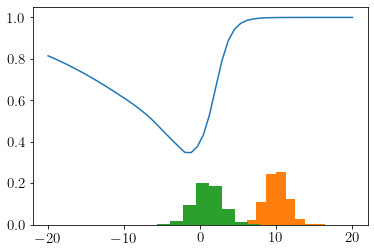

In [54]:
ts = np.linspace(-20, 20)
ys = model.predict(ts)
plt.plot(ts, ys)
plt.hist(sim_reco, density = True)
plt.hist(data_reco, density = True)

# Binary Cross Entropy

In [78]:
n_iter = 10
batch_size = 10000

labels0 = np.zeros(len(sim_reco))
labels_unknown = np.ones(len(data_reco))

xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(n_iter, 2, len(sim_reco)))
# shape = (iteration, step, event)


# Create neural network
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [79]:
# Initial weights
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

weight_bins = np.linspace(0, 5, 41)

In [80]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # this is why we zip the weights in with the labels.
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)

In [81]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [82]:
for i in range(n_iter):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping

ITERATION: 2

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping

ITERATION: 3

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping

ITERATION: 4

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping

ITERATION: 5

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping


C:\Users\septi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.



STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping


In [83]:
iterations = 10
bins = np.linspace(-8, 8, 41)

ITERATION 1:


C:\Users\septi\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


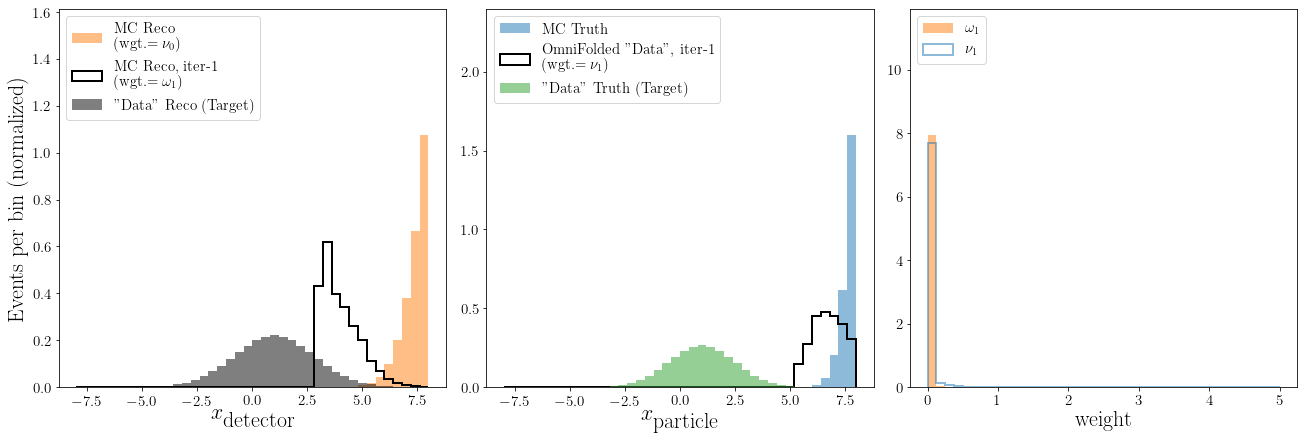

ITERATION 2:


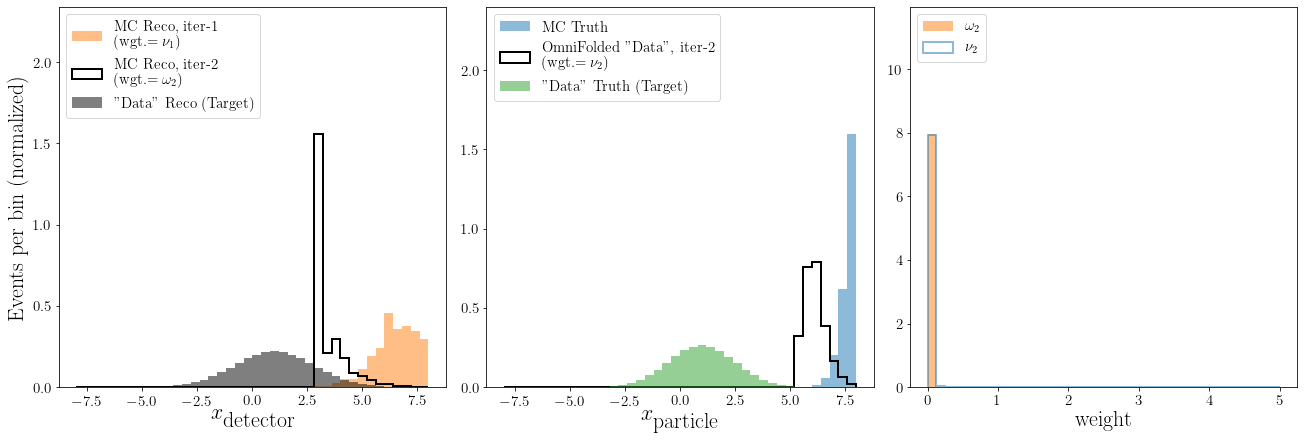

ITERATION 3:


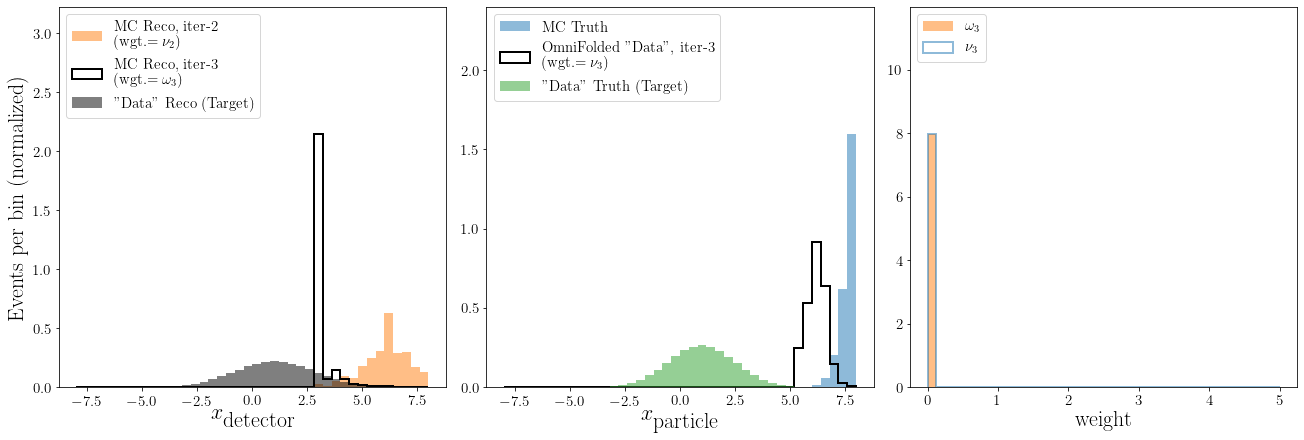

ITERATION 4:


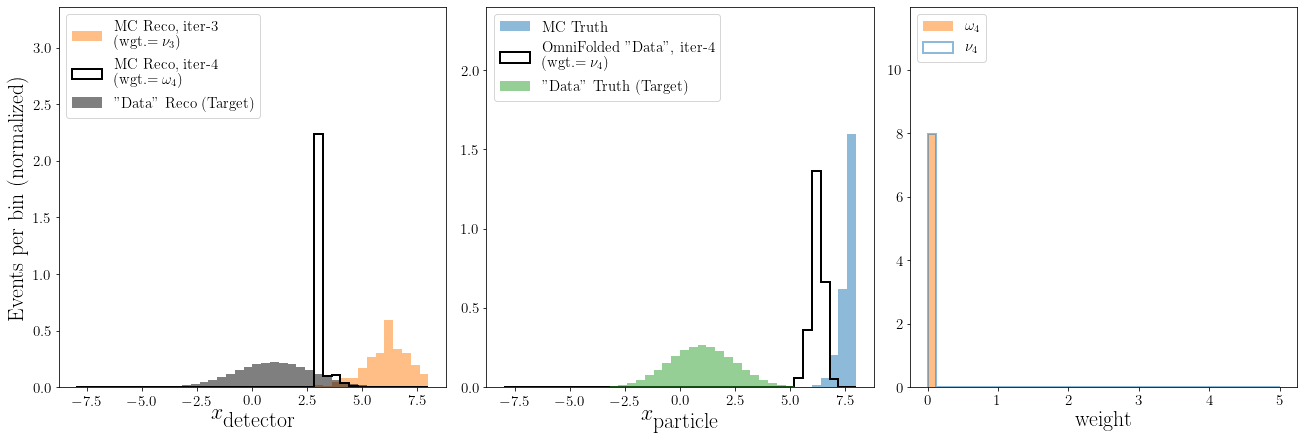

ITERATION 5:


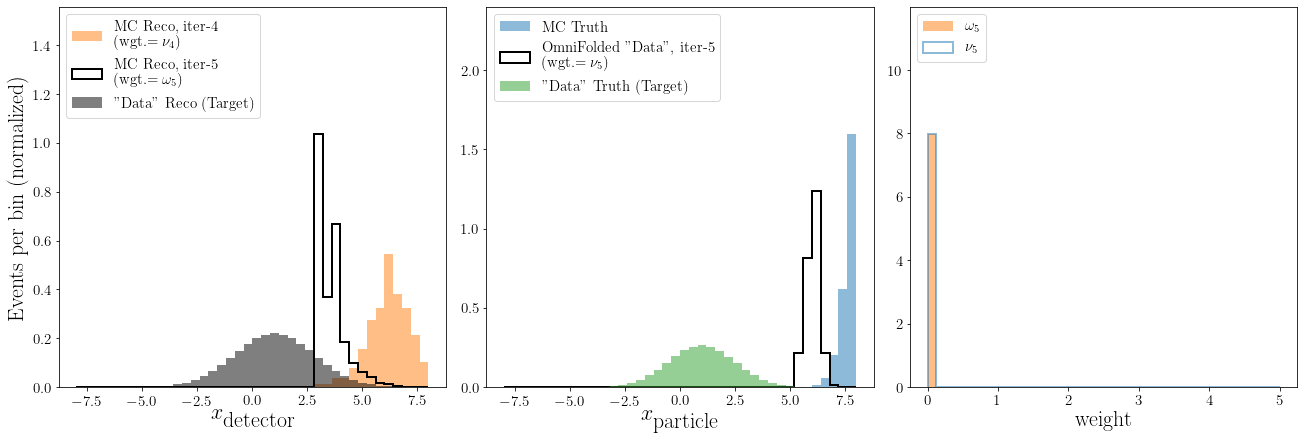

ITERATION 6:


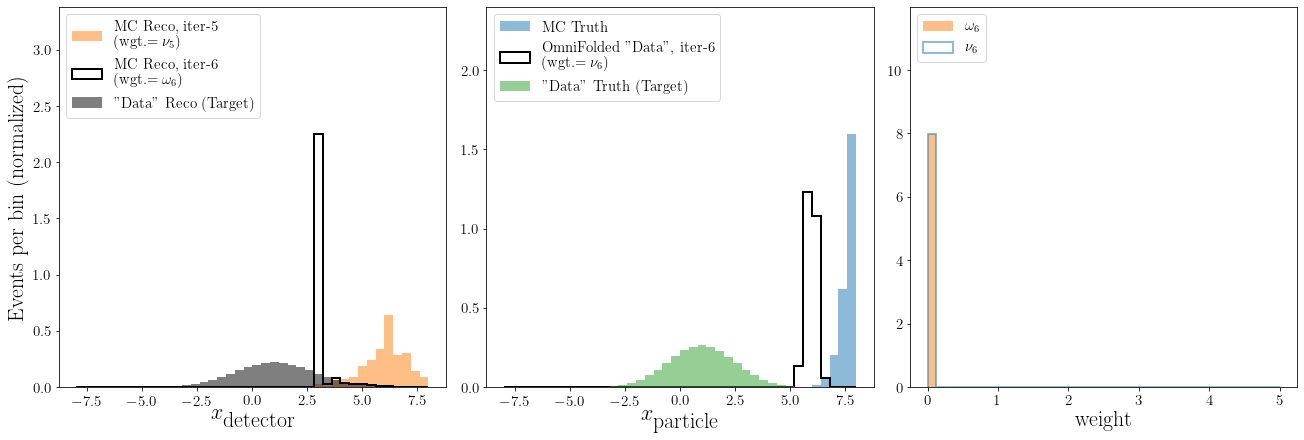

ITERATION 7:


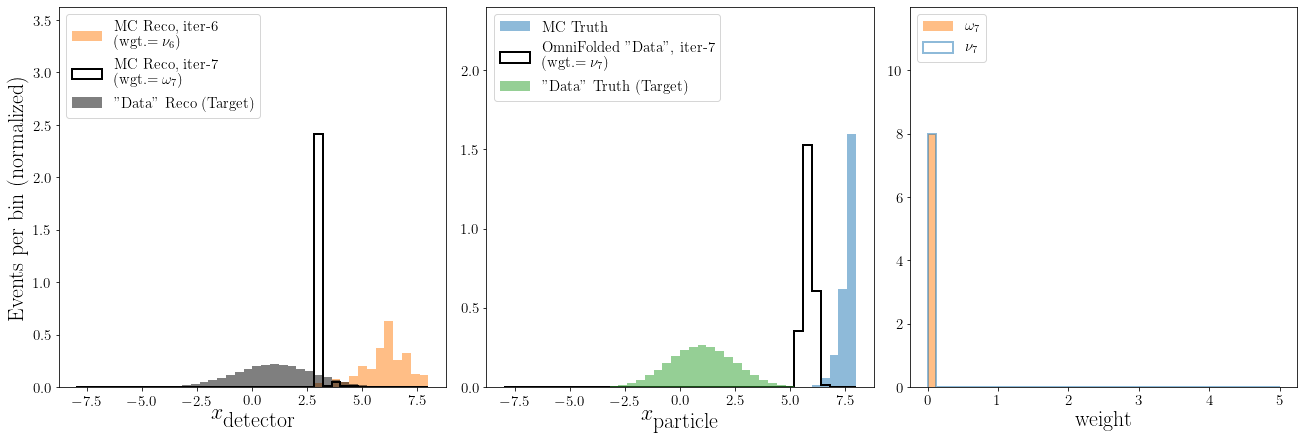

ITERATION 8:


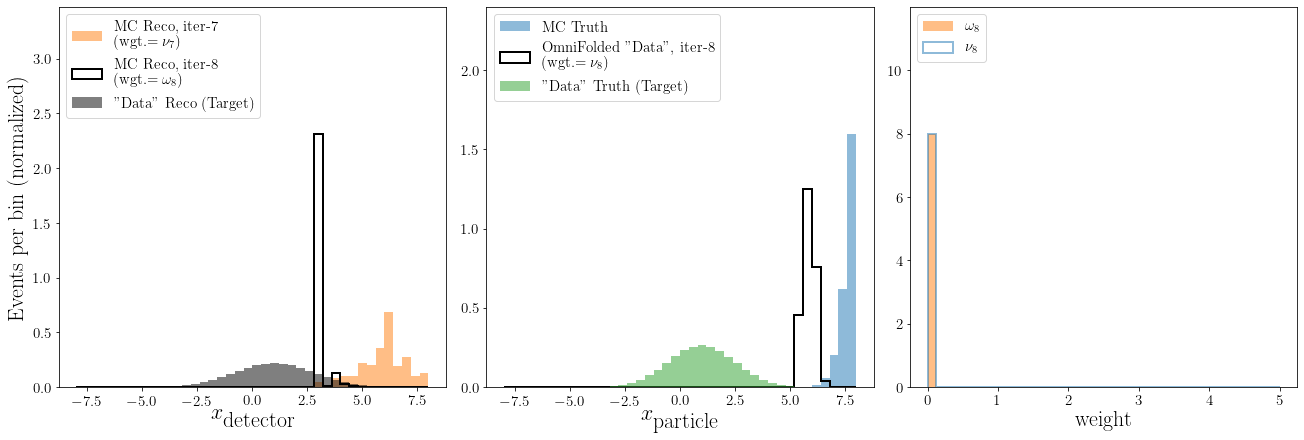

ITERATION 9:


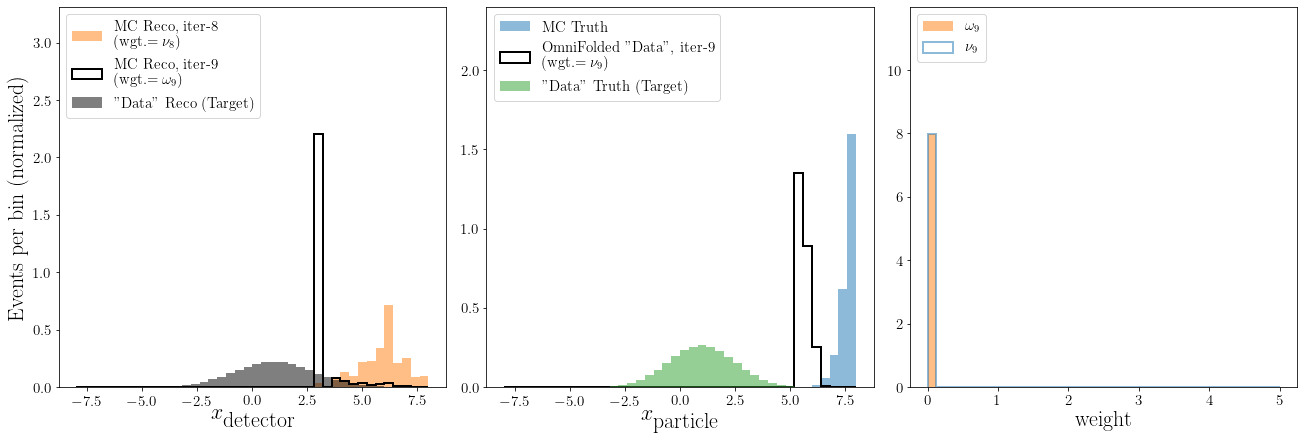

ITERATION 10:


C:\Users\septi\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ValueError: Axis limits cannot be NaN or Inf

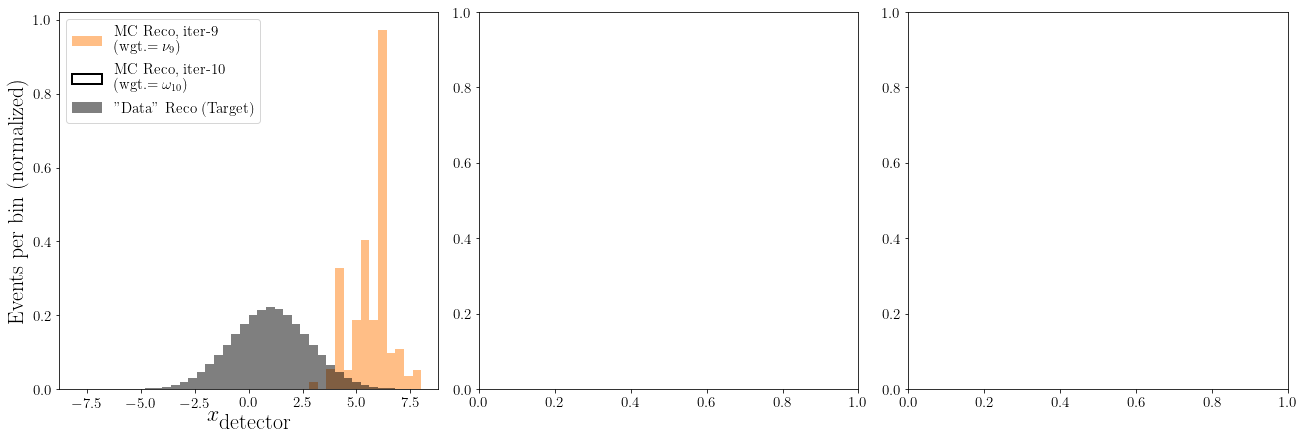

In [84]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hR1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hR2, _, _ = ax[0].hist(data_reco,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textrm{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    hT0, _, _ = ax[1].hist(sim_truth,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hT1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{}$)'.format(i + 1),
                           **plot_style_1)
    hT2, _, _ = ax[1].hist(data_truth,
                           bins=bins,
                           label='"Data" Truth (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])

    #     ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()

# Mean Squared Error

In [39]:
n_iter = 10
batch_size = 10000

labels0 = np.zeros(len(sim_reco))
labels_unknown = np.ones(len(data_reco))

xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(n_iter, 2, len(sim_reco)))
# shape = (iteration, step, event)


# Create neural network
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [40]:
# Initial weights
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

weight_bins = np.linspace(0, 5, 41)

In [41]:
def weighted_mse(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * -K.square(1. - y_pred) +
                         (1 - y_true) * -K.square(y_pred))
    
    return K.mean(t_loss)

In [42]:
for i in range(n_iter):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_mse,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_mse,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping

ITERATION: 2

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping

ITERATION: 3

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping

ITERATION: 4

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping

ITERATION: 5

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping


ITERATION 1:


C:\Users\septi\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


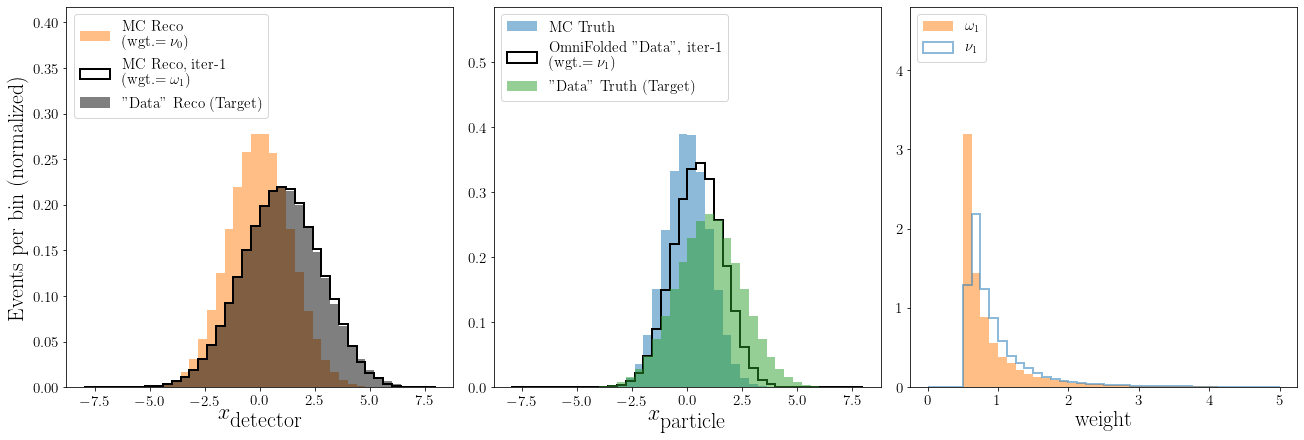

ITERATION 2:


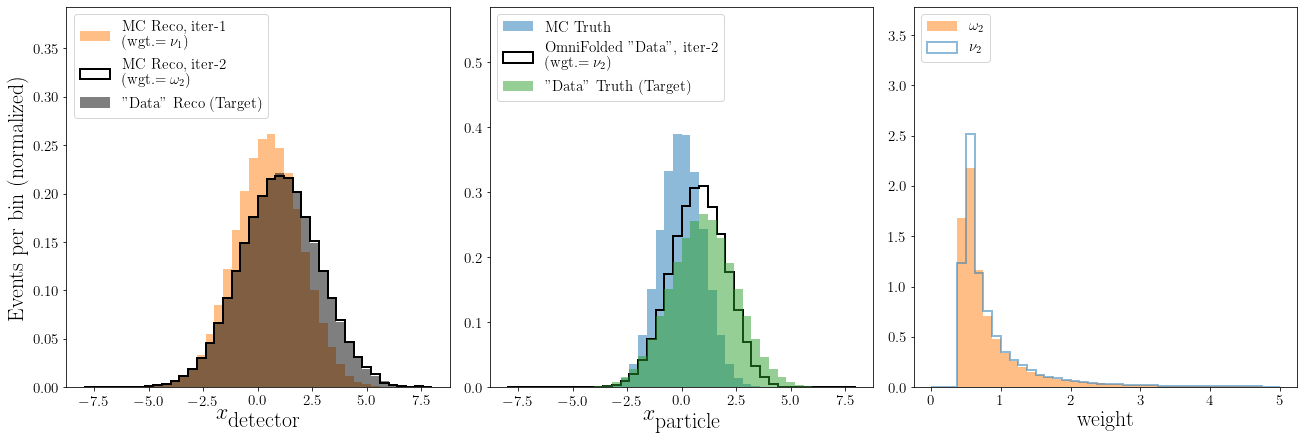

ITERATION 3:


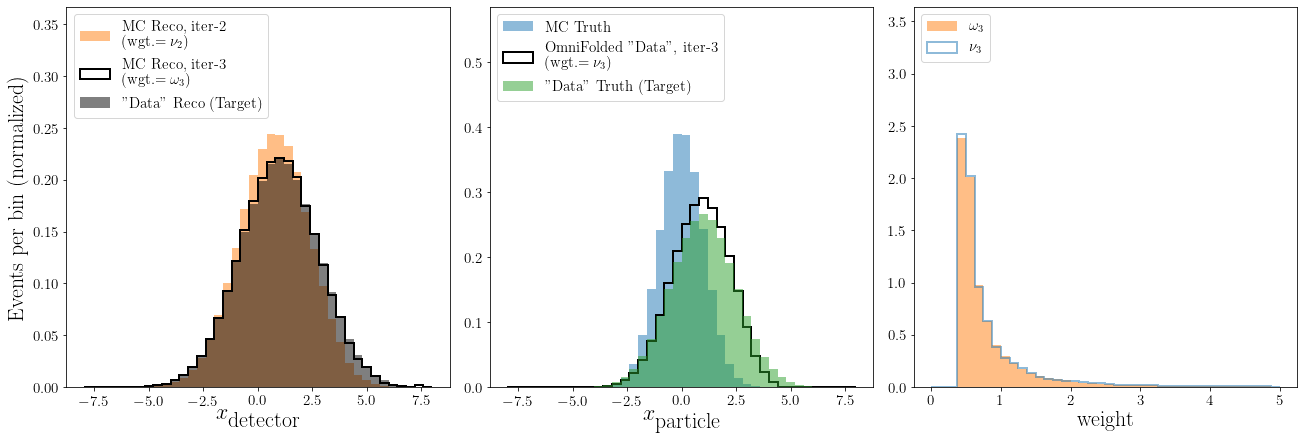

ITERATION 4:


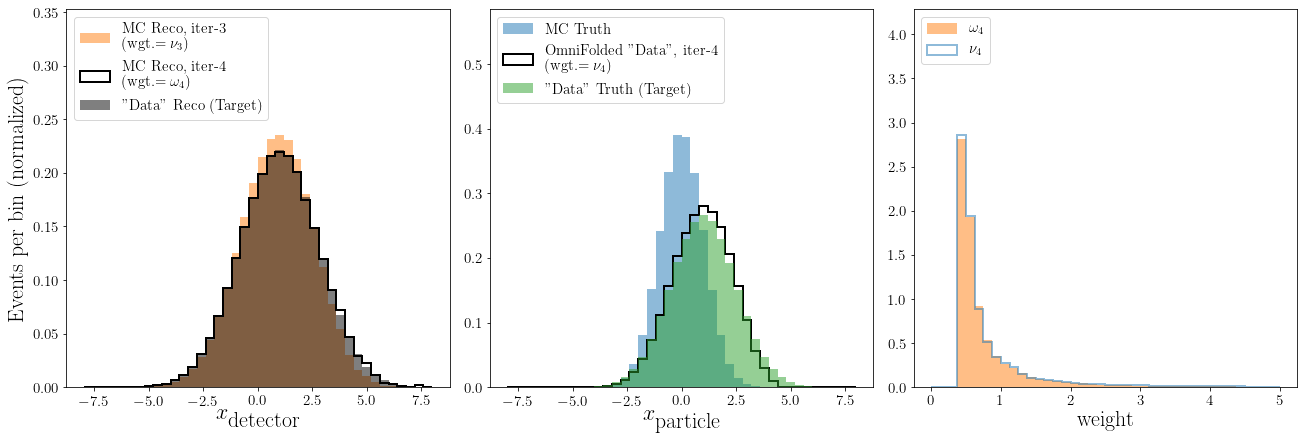

ITERATION 5:


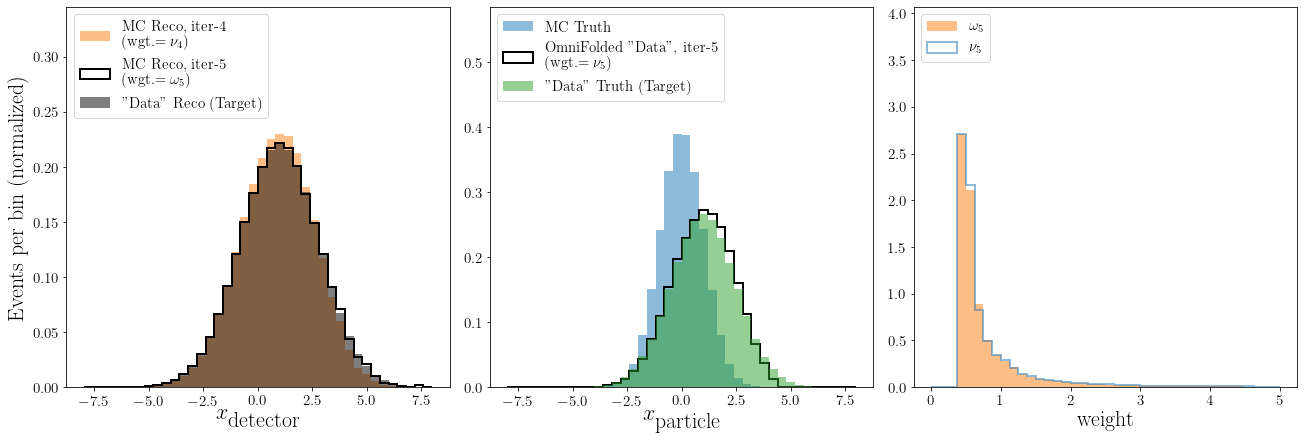

ITERATION 6:


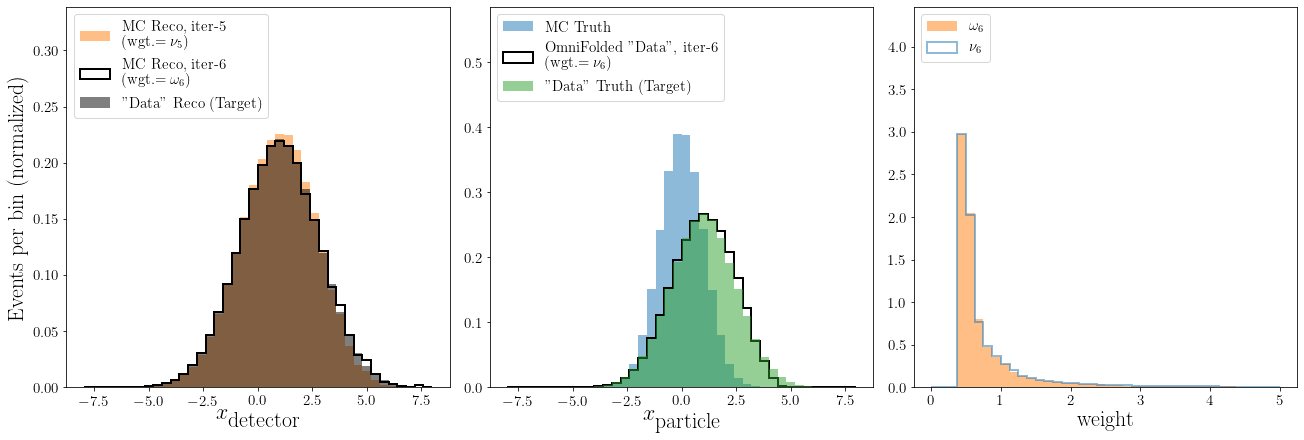

ITERATION 7:


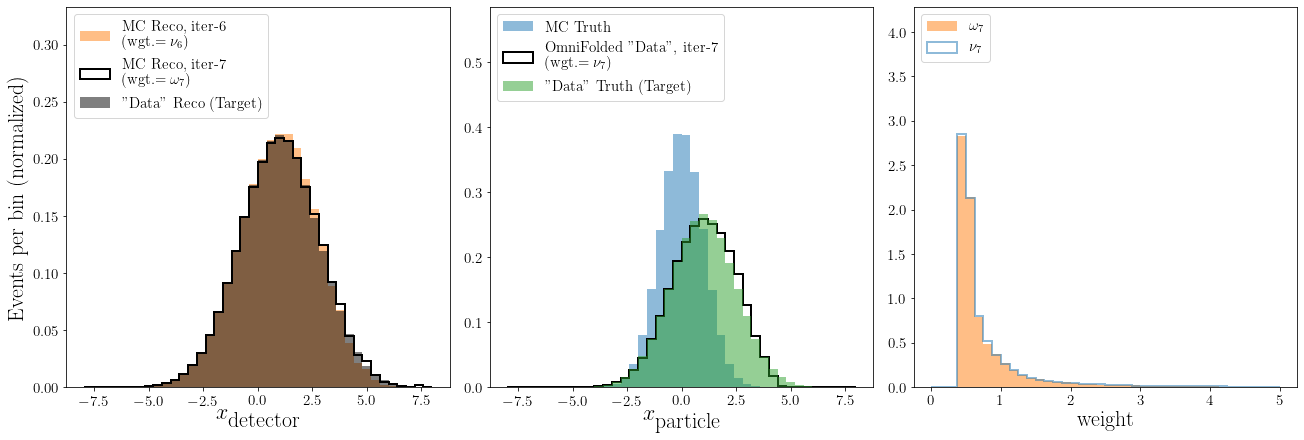

ITERATION 8:


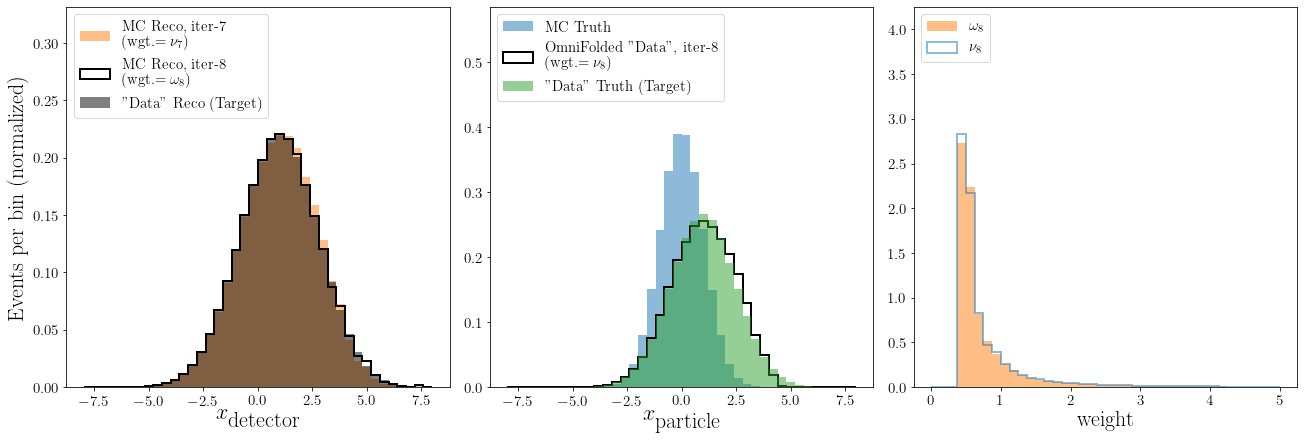

ITERATION 9:


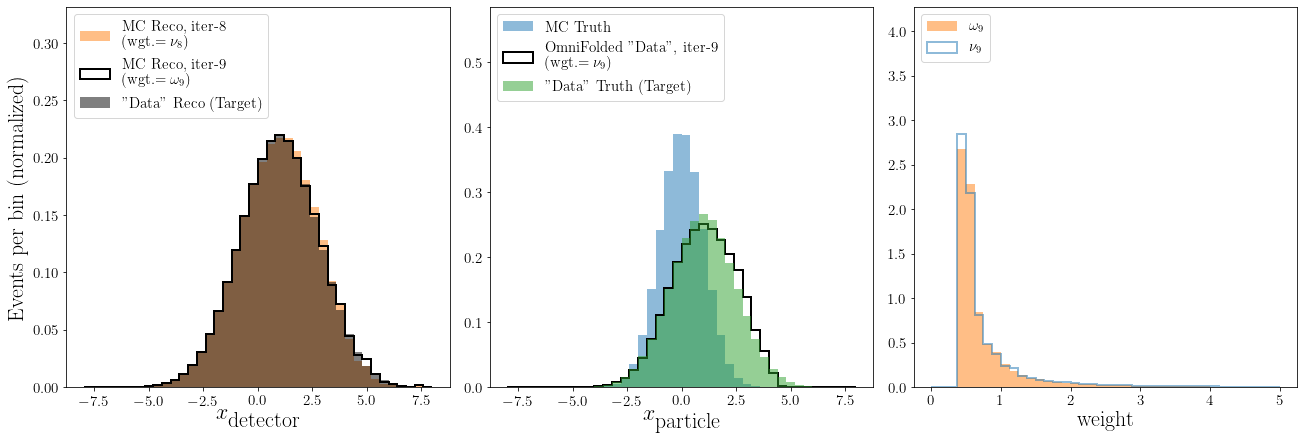

ITERATION 10:


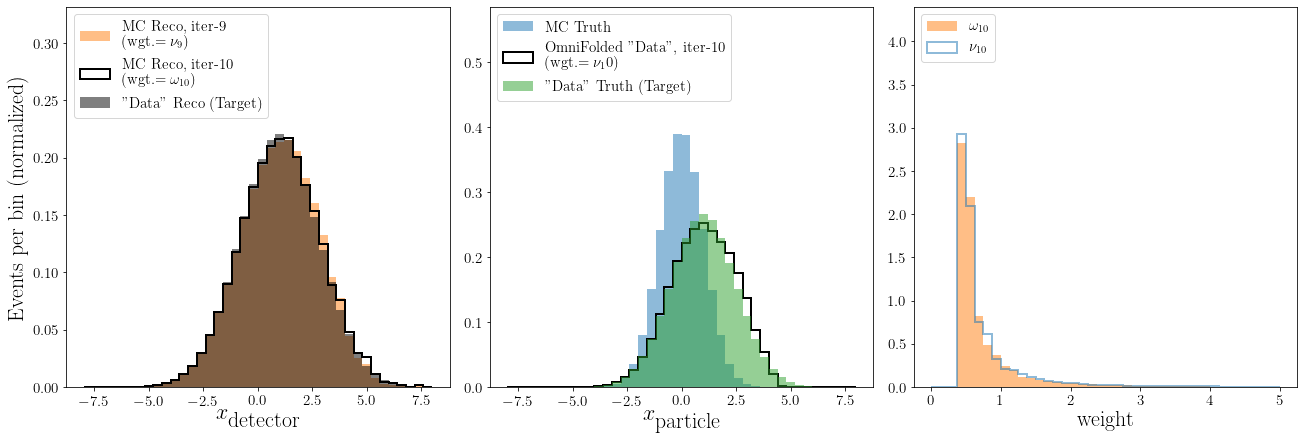

In [43]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hR1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hR2, _, _ = ax[0].hist(data_reco,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textrm{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    hT0, _, _ = ax[1].hist(sim_truth,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hT1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{}$)'.format(i + 1),
                           **plot_style_1)
    hT2, _, _ = ax[1].hist(data_truth,
                           bins=bins,
                           label='"Data" Truth (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])

    #     ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()

# Square Root

In [61]:
n_iter = 10
batch_size = 10000

labels0 = np.zeros(len(sim_reco))
labels_unknown = np.ones(len(data_reco))

xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(n_iter, 2, len(sim_reco)))
# shape = (iteration, step, event)


# Create neural network
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
# no activation since sr loss
outputs = Dense(1)(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [62]:
# Initial weights
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

weight_bins = np.linspace(0, 5, 41)

In [63]:
def weighted_square_root(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * -1. / K.sqrt(y_pred) +
                         (1 - y_true) * -K.sqrt(y_pred))
    
    return K.mean(t_loss)

In [64]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=1000)
    weights = f
    return np.squeeze(weights)

In [65]:
for i in range(n_iter):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_square_root,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_square_root,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

ITERATION: 2

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

ITERATION: 3

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

ITERATION: 4

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

ITERATION: 5

STEP 1

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping

STEP 2

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


In [67]:
iterations = 10

ITERATION 1:


C:\Users\septi\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ValueError: Axis limits cannot be NaN or Inf

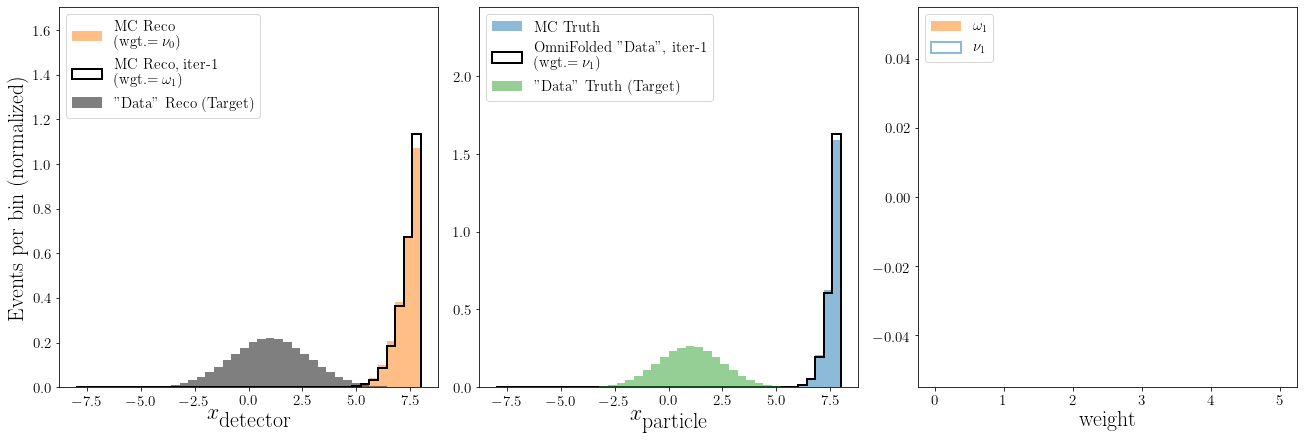

In [68]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hR1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hR2, _, _ = ax[0].hist(data_reco,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textrm{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    hT0, _, _ = ax[1].hist(sim_truth,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hT1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{}$)'.format(i + 1),
                           **plot_style_1)
    hT2, _, _ = ax[1].hist(data_truth,
                           bins=bins,
                           label='"Data" Truth (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])

    #     ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()

# Maximum Likelihood Classifier

In [ ]:
n_iter = 10
batch_size = 10000

labels0 = np.zeros(len(sim_reco))
labels_unknown = np.ones(len(data_reco))

xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(n_iter, 2, len(sim_reco)))
# shape = (iteration, step, event)


# Create neural network
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
# no activation since mlc loss
outputs = Dense(1)(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
# Initial weights
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

weight_bins = np.linspace(0, 5, 41)

In [ ]:
def weighted_mlc_loss(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * (1 - y_pred))
    
    return K.mean(t_loss)

In [ ]:
for i in range(n_iter):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_mlc_loss,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_mlc_loss,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push

In [ ]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hR1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hR2, _, _ = ax[0].hist(data_reco,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textrm{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    hT0, _, _ = ax[1].hist(sim_truth,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hT1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{}$)'.format(i + 1),
                           **plot_style_1)
    hT2, _, _ = ax[1].hist(data_truth,
                           bins=bins,
                           label='"Data" Truth (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])

    #     ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()